# HEPDataStorage #
The raredecay package offers a comfortable way to hold your data together. Dealing with machine learning problems and data in general can be tricky, as you may want to convert data to the right format, keep also track of its weights as well as its name where you actually often just want to do the same thing over and over again.

Equivalently to pythons philosophy, that code is much more read than written and therefore it is fine if writting takes more time in favour of readability, the HEPDataStorage provides the same for data-management. Specify the data once at the beginning and everything else is routine. So let's start with the "more time consuming" thing, the initialization:

In [1]:
from raredecay.tools.data_storage import HEPDataStorage
# a warning will probably occure that it cannot import root_numpy. A very strange error which only occured (for me)
# in the Jupyter Notebook but never in a console.

/home/mayou/Documents/uniphysik/Bachelor_thesis/python_workspace/HEP-decay-analysis/raredecay/tools/data_tools.py:20: UserWarning: could not import from root_numpy!
  warnings.warn("could not import from root_numpy!")


### Data formats ###
Currently, there are two types of data implemented: ROOT-trees as well as pandas DataFrames

#### ROOT Tree ####

In [2]:
# "root-dict", it contains all information for root2rec to convert a tree
root_dict1 = dict(filenames='/home/data/my_root_tree.root',
                  treename='DecayTree',
                  branches=['B_PT', 'nTracks', 'nSPDHits'])

# The actual initialization. Uncomment to try (only works if no warning occured above)
#real_data = HEPDataStorage(data=root_dict1,
#                           sample_weights='signal_sw'  # using a root-dict, you can simply use the branch name
#                                                       # where the weights are stored
#                           data_name="Real signal sWeighted",
#                           data_name_addition="cut",
#                           #target=1  # label the data with 1, 0 or an array containing 1 and 0. Often not needed
#                           )

#### Pandas DataFrame ####
A pandas DataFrame can also be passed as data.

In [3]:
import pandas as pd
import numpy as np
# 5 columns, 100 rows
data1 = pd.DataFrame(np.random.normal(size=(100, 5)), columns=['one', 'two', 'three', 'four', 'five'])  

data1 = HEPDataStorage(data1,
                      sample_weights=abs(np.random.normal(size=100)),
                      data_name="random test-data")

# Second DataStorage
data2 = pd.DataFrame(np.random.normal(size=(100, 5)), columns=['one', 'two', 'three', 'four', 'five'])  

data2 = HEPDataStorage(data2,
                      sample_weights=abs(np.random.normal(size=100)),
                      data_name="random test-data")

## Plotting  ##
To start with the benefits, we may first plot our data in any convenient way. If the script was initialized and an output path was given, the figures would be automatically saved to the specified directory.

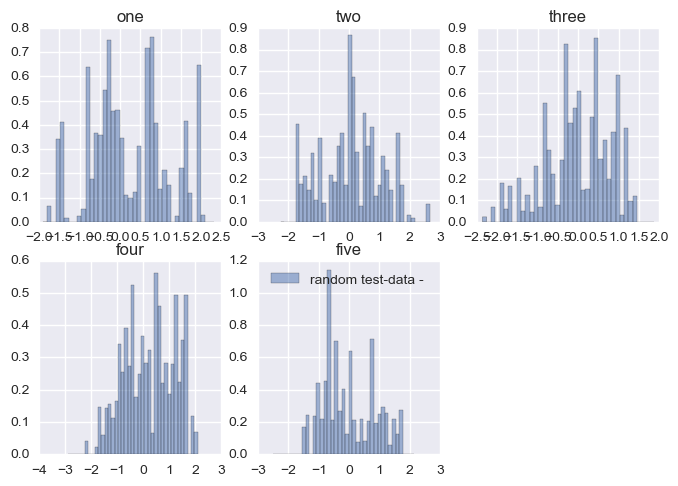

In [4]:
data1.plot(figure="My data", title=None)

## Using the data ##
We can simply get the data as a pandas DataFrame (even if we entered a root-dict) and reassign it (for example to make some operations on the data)

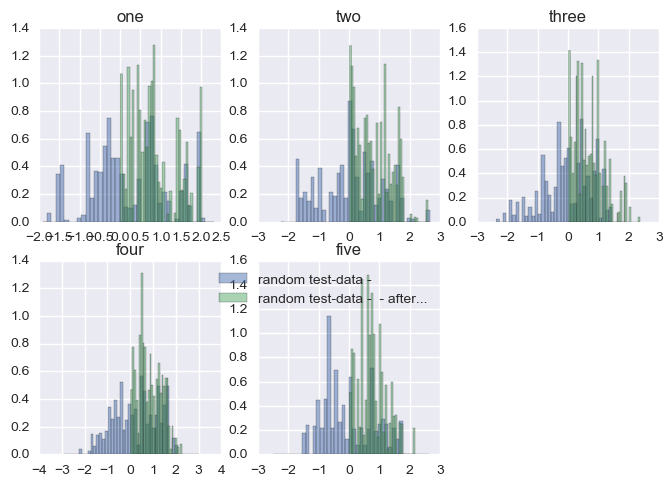

In [5]:
data_temp = data1.pandasDF()
data_temp = data_temp.apply(abs)  # pandas DataFrame method (*apply*), which applies *abs()* to all entries.
data1.set_data(data_temp)

# plot to see the data now
data1.plot(data_name="after...")

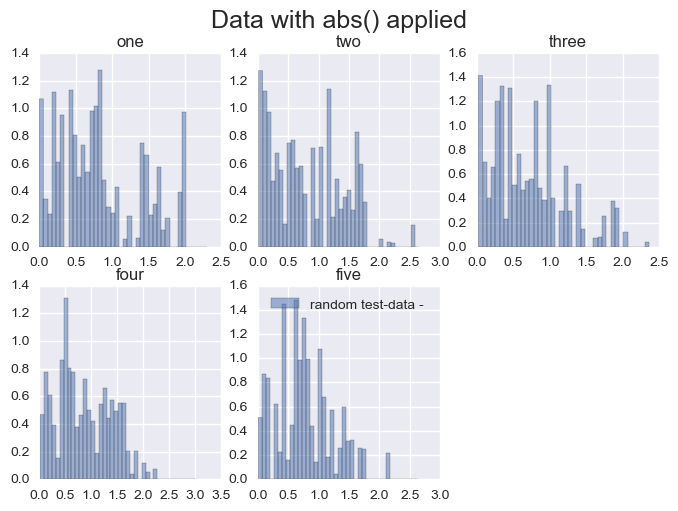

In [6]:
# To not plot again over the one before, select a new figure
data1.plot(figure="Data abs applied", title="Data with abs() applied")

## Making a dataset ##
Usually, when dealing with machine learning tasks, we want to concatenate two datasets (bkg, signal etc). Or more precise, we want to concatenate:
* data
* weights
* target

This can be easily achieved with the *make_dataset()* method.

In [7]:
data, targets, weights = data1.make_dataset(second_storage=data2,  # we can directly provide a second storage
                                            weights_ratio=1,  # Feature: normalize both weights
                                            targets_from_data=False  # Default value.
                                                # -> the method assumes data1 is label 0 and data2 is label 1
                                            )

## Using KFolds ##
Often, the data in this format is not yet the end. We want to either split it or use KFolding technique. There are automatic KFolding Classifiers in the REP for example, but what if you want to do more with your data?

The method *make_folds()* splits the HEPDataStorage into n folds (where n-1/n of the data is in the training set and 1/n in the test set)
By calling *get_fold()* (for 0 to n-1) you can get the different folds.

In [8]:
data1.make_folds(10)  # creating 10 folds. So far, nothing changed
train1, test1 = data1.get_fold(0)  # get the first train/test set
print "Type of data1: ", type(data1), "\ntype of train1", type(train1), "\nand test1", type(test1)

Type of data1:  <class 'raredecay.tools.data_storage.HEPDataStorage'> 
type of train1 <class 'raredecay.tools.data_storage.HEPDataStorage'> 
and test1 <class 'raredecay.tools.data_storage.HEPDataStorage'>


This way we can simply loop through the folds

In [9]:
n_folds = 10
data1.make_folds(n_folds)
data2.make_folds(n_folds)
for fold in range(n_folds):
    train1, test1 = data1.get_fold(fold)
    train2, test2 = data2.get_fold(fold)
    data_tr, target_tr, weights_tr = train1.make_dataset(train2)  # It is still a HEPDataStorage
    data_te, target_te, weights_te = test1.make_dataset(test2)
    # now, for example:
    # clf.fit(data_tr,...)
    # clf.predict(data_te,...)
    # We could of course also split it even more!
    train1.make_folds(3)
    train11, test11 = train1.get_fold(0)  # and so on...

### Recover 2/3-1/3 split ###
A widely used split of the data is 2/3 training set and 1/3 test set. By creating 3 folds and get fold number 0 (or 1 or 2), you get exactly that split.

## Setting and getting ##
Setting weights and targets is as easy as setting the data above. The prefered format is a pandas Series (resp. a DataFrame for data).
If you had weights before and want to reset them, you can also just assign 1

In [10]:
temp_weights = data1.get_weights()
print "Weights get before\n", temp_weights[0:5]
data1.set_weights(1)
print "Weights set to 1\n", data1.get_weights()[0:5]
data1.set_weights(temp_weights)
print "Weigth get after they have been set back\n", data1.get_weights()[0:5]

Weights get before
0    0.708406
1    1.822919
2    0.523721
3    0.361112
4    1.859828
dtype: float64
Weights set to 1
0    1
1    1
2    1
3    1
4    1
dtype: int64
Weigth get after they have been set back
0    0.708406
1    1.822919
2    0.523721
3    0.361112
4    1.859828
dtype: float64


## Memory efficiency ##
The DataStorage is built for memory efficiency (and not computation time). Conversions are done on request (like the weights above, before the *get_weights()* there was no array containing 1s). Methods in the raredecay package know that and can use it.

But that's an internal, unnecessary detail ;)